In [108]:
import pandas as pd
import psycopg2
from sshtunnel import SSHTunnelForwarder
import matplotlib.pyplot as plt

In [144]:
data = pd.read_csv('users.csv')
data = data.drop('Label',1)
data = data.drop('timeset',1)
data = data.rename(columns = {'Id':'user_id'})
topic = pd.read_csv('topics.csv')

In [98]:
def fetchTopic(topic):
    idtweet_topic_pol = "SELECT twitter_id FROM public.tweet JOIN public.tweet_topic ON id_tweet = id WHERE id_topic = "+topic
    replies = "SELECT id, user_id FROM public.tweet JOIN ("+ idtweet_topic_pol +") as Pol ON tweet.in_reply_twitter_id = Pol.twitter_id"
    replies_sentiment = "SELECT id, user_id, sentiment FROM tweet_sentiment JOIN ("+ replies +") as Rep ON id_tweet = id WHERE score >= 0.2;"
    try:
        with SSHTunnelForwarder(
            ('161.35.123.231', 22),
            ssh_username="postgres",
            ssh_password="dbConn2021!", 
            remote_bind_address=('localhost', 5432)) as server:

            keepalive_kwargs = {
                "keepalives": 1,
                "keepalives_idle": 60,
                "keepalives_interval": 10,
                "keepalives_count": 5
            }
            params = {
                'database': 'tweetproject',
                'user': 'postgres',
                'password': 'padova2021',
                'host': server.local_bind_host,
                'port': server.local_bind_port,
                **keepalive_kwargs
                }

            conn = psycopg2.connect(**params)
            curs = conn.cursor()
            curs.execute(replies_sentiment)
            output = pd.DataFrame.from_records(curs, columns = ['id','user_id','sentiment'])
            return output

    except (Exception) as error:
            print("Connection Failed")
            print(error)

In [100]:
replies = {}
for tp_id in topic['id']:
    replies[tp_id] = fetchTopic(str(tp_id))

In [106]:
mod_classes = data.groupby('modularity_class')
modularity_sentiment = {}

for tp_id,tp_label in zip(topic['id'],topic['label']):
    out = pd.DataFrame(columns = ('modularity_class','sentiment'))
    for community in mod_classes:
        temp = community[1].merge(replies[tp_id], how = 'inner', on = 'user_id')
        out = pd.concat([out,temp[['modularity_class', 'sentiment']]])
    out.to_csv('data/'+tp_label+'.csv', index = False)
    modularity_sentiment[tp_label] = out

In [186]:
classes = {
    0 : 'extreme right',
    1 : 'extreme left',
    2 : 'center left',
    3 : 'left',
    4 : 'right'
}
order = [1,3,2,4,0]

1    1
3    3
2    2
4    4
0    0
dtype: int64


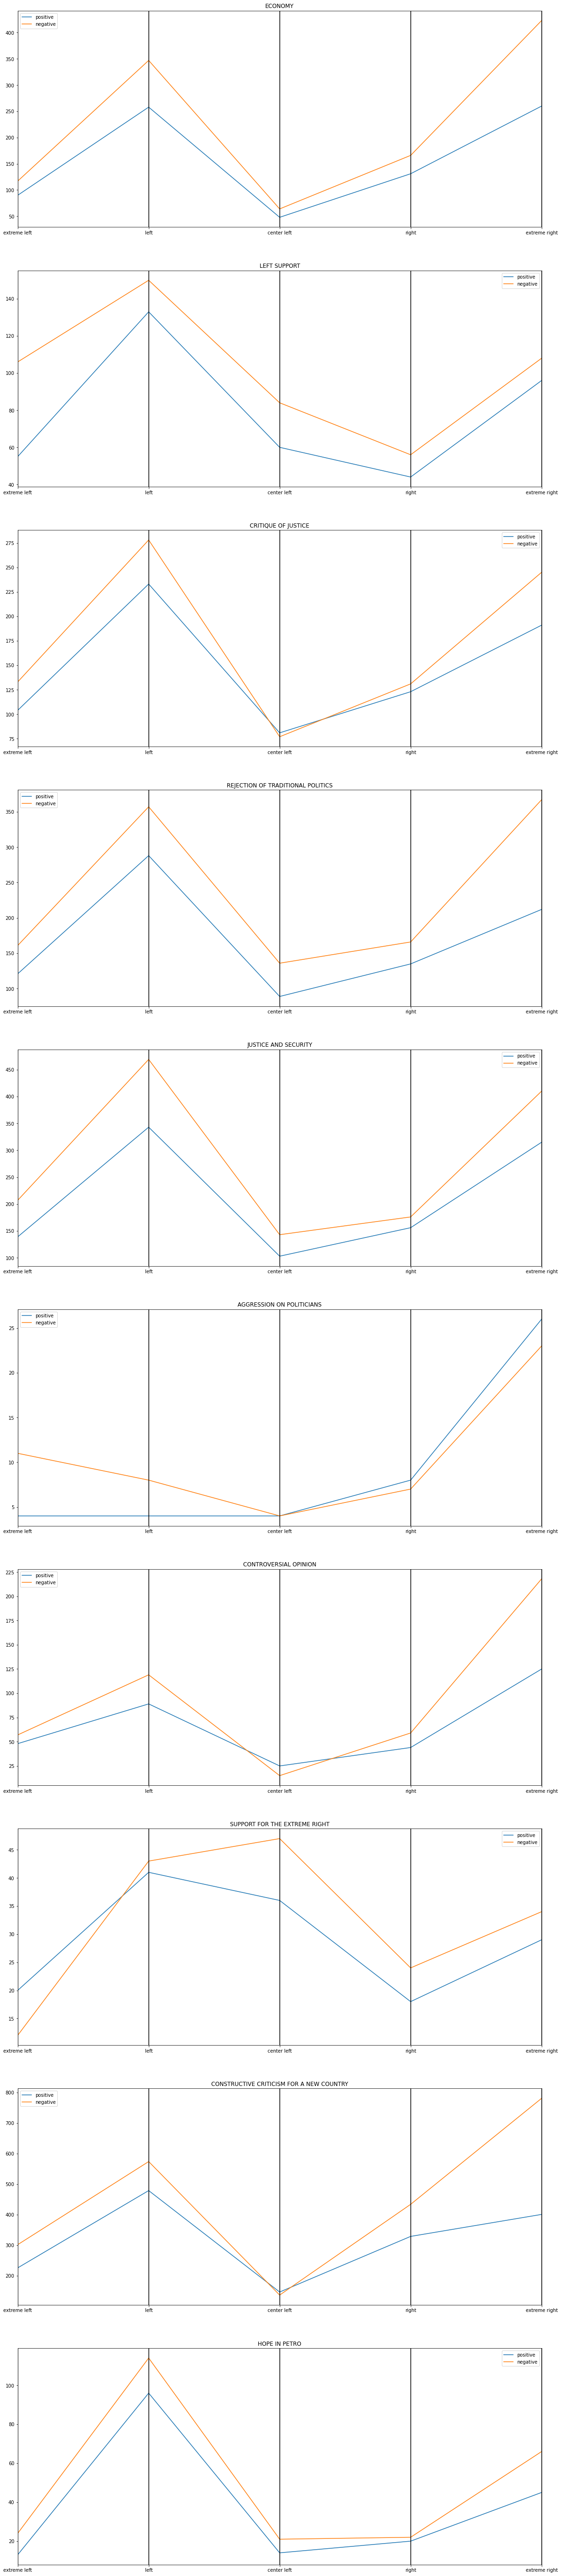

In [194]:
fig, ax = plt.subplots(len(modularity_sentiment), figsize =(20,100))
for idx,tp_label in enumerate(modularity_sentiment):
    topic_sentiments = modularity_sentiment[tp_label]
    positive = topic_sentiments[topic_sentiments['sentiment'] == 1].groupby('modularity_class').count()['sentiment']
    negative = topic_sentiments[topic_sentiments['sentiment'] == 0].groupby('modularity_class').count()['sentiment']
    
    ax[idx].set_title(tp_label)
    ax[idx].plot(tuple(classes.keys()),positive[order], label = 'positive')
    ax[idx].plot(tuple(classes.keys()),negative[order], label = 'negative')
    for l in classes.keys():
        ax[idx].axvline(l, color ='k')
    ax[idx].set_xticks(tuple(classes.keys()))
    ax[idx].set_xticklabels(pd.Series(classes.values())[order])
    ax[idx].set_xlim(0,4)
    ax[idx].legend()